## Feed-Forward Neural Net

In [6]:
# Reproduce results
set.seed(1234567)

### 1. Neural Net in R (5 short functions to care about)

Initialise neural network biase and weights matricies

In [7]:
neuralnetwork <- function(sizes)
{
  num_layers <- length(sizes)
  listw <- sizes[1:length(sizes)-1] # Skip last (weights from 1st to 2nd-to-last)
  listb <-  sizes[-1]  # Skip first element (biases from 2nd to last)
  
  # Initialise with gaussian distribution for biases and weights
  biases <- lapply(seq_along(listb), function(idx){
    r <- listb[[idx]]
    matrix(rnorm(n=r), nrow=r, ncol=1)
  })
  weights <- lapply(seq_along(listb), function(idx){
    c <- listw[[idx]]
    r <- listb[[idx]]
    matrix(rnorm(n=r*c), nrow=r, ncol=c)
  })
  
  # Return
  list(sizes, num_layers, biases, weights)
}

Return the derivative of the cost function (quadratic or cross-entropy)

In [8]:
cost_delta <- function(method, z, a, y)
{
  if (method=='mse'){
    # COST: 0.5*linalg.norm(a-y)**2
    return (a-y)*sigmoid_prime(z)
  } else if(method=='ce'){
    # COST: sum(-y*log(a)-(1-y)*log(1-a))
    return (a-y)
  }
}

Perform stochastic-gradient descent to minimise cost function

In [9]:
SGD <- function(training_data, testing_data, epochs, mini_batch_size, lr, C, sizes, num_layers, biases, weights, verbose=FALSE)
{
  # Every epoch
  for (j in 1:epochs){
    # Stochastic mini-batch (shuffle data)
    training_data <- sample(training_data)
    # Partition set into mini-batches
    mini_batches <- split(training_data, 
                          ceiling(seq_along(training_data)/mini_batch_size))
    # Feed forward (and back) all mini-batches
    for (k in 1:length(mini_batches)) {
      # Update biases and weights
      res <- update_mini_batch(mini_batches[[k]], lr, C, sizes, num_layers, biases, weights)
      biases <- res[[1]]
      weights <- res[[-1]]
    }
    # Logging
    if(verbose){if(j %% 1 == 0){
      cat("Epoch: ", j, " complete")
      # Print acc and hide confusion matrix
      confusion <- evaluate(testing_data, biases, weights)
      }}
  }
  cat("Training complete")
  # Return trained biases and weights
  list(biases, weights)
}

Update the biase and weights matricies for each mini-batch

In [10]:
update_mini_batch <- function(mini_batch, lr, C, sizes, num_layers, biases, weights)
{
  nmb <- length(mini_batch)
  listw <- sizes[1:length(sizes)-1] 
  listb <-  sizes[-1]  
  
  # Initialise updates with zero vectors (for EACH mini-batch)
  nabla_b <- lapply(seq_along(listb), function(idx){
    r <- listb[[idx]]
    matrix(0, nrow=r, ncol=1)
  })
  nabla_w <- lapply(seq_along(listb), function(idx){
    c <- listw[[idx]]
    r <- listb[[idx]]
    matrix(0, nrow=r, ncol=c)
  })  
  
  # Go through mini_batch
  for (i in 1:nmb){
    x <- mini_batch[[i]][[1]]
    y <- mini_batch[[i]][[-1]]
    # Back propogation will return delta
    # Backprop for each obeservation in mini-batch
    delta_nablas <- backprop(x, y, C, sizes, num_layers, biases, weights)
    delta_nabla_b <- delta_nablas[[1]]
    delta_nabla_w <- delta_nablas[[-1]]
    # Add on deltas to nabla
    nabla_b <- lapply(seq_along(biases),function(j)
      unlist(nabla_b[[j]])+unlist(delta_nabla_b[[j]]))
    nabla_w <- lapply(seq_along(weights),function(j)
      unlist(nabla_w[[j]])+unlist(delta_nabla_w[[j]]))
  }
  # After mini-batch has finished update biases and weights:
  # i.e. weights = weights - (learning-rate/numbr in batch)*nabla_weights
  # Opposite direction of gradient
  weights <- lapply(seq_along(weights), function(j)
    unlist(weights[[j]])-(lr/nmb)*unlist(nabla_w[[j]]))
  biases <- lapply(seq_along(biases), function(j)
    unlist(biases[[j]])-(lr/nmb)*unlist(nabla_b[[j]]))
  # Return
  list(biases, weights)
}

Backpropogation algorithm to calculate partial derivatives using chain-rule (to update mini-batch)

In [11]:
backprop <- function(x, y, C, sizes, num_layers, biases, weights)
{
  # Initialise updates with zero vectors
  listw <- sizes[1:length(sizes)-1] 
  listb <-  sizes[-1]  
  
  # Initialise updates with zero vectors (for EACH mini-batch)
  nabla_b_backprop <- lapply(seq_along(listb), function(idx){
    r <- listb[[idx]]
    matrix(0, nrow=r, ncol=1)
  })
  nabla_w_backprop <- lapply(seq_along(listb), function(idx){
    c <- listw[[idx]]
    r <- listb[[idx]]
    matrix(0, nrow=r, ncol=c)
  })  
  
  # First:
  # Feed-forward (get predictions)
  activation <- matrix(x, nrow=length(x), ncol=1)
  activations <- list(matrix(x, nrow=length(x), ncol=1))
  # z = f(w.x + b)
  # So need zs to store all z-vectors
  zs <- list()
  for (f in 1:length(biases)){
    b <- biases[[f]]
    w <- weights[[f]]
    w_a <- w%*%activation
    b_broadcast <- matrix(b, nrow=dim(w_a)[1], ncol=dim(w_a)[-1])
    z <- w_a + b
    zs[[f]] <- z
    activation <- sigmoid(z)
    activations[[f+1]] <- activation  # Activations already contain one element
  }
  # Second:
  # Backwards (update gradient using errors)
  # Last layer
  delta <- cost_delta(method=C, z=zs[[length(zs)]], a=activations[[length(activations)]], y=y)
  nabla_b_backprop[[length(nabla_b_backprop)]] <- delta
  nabla_w_backprop[[length(nabla_w_backprop)]] <- delta %*% t(activations[[length(activations)-1]])
  # Second to second-to-last-layer
  # If no hidden-layer reduces to multinomial logit
  if (num_layers > 2) {
      for (k in 2:(num_layers-1)) {
        sp <- sigmoid_prime(zs[[length(zs)-(k-1)]])
        delta <- (t(weights[[length(weights)-(k-2)]]) %*% delta) * sp
        nabla_b_backprop[[length(nabla_b_backprop)-(k-1)]] <- delta
        testyy <- t(activations[[length(activations)-k]])
        nabla_w_backprop[[length(nabla_w_backprop)-(k-1)]] <- delta %*% testyy
      }
  }
  return_nabla <- list(nabla_b_backprop, nabla_w_backprop)
  return_nabla
}

### Some helper functions (ignore these)

#### These run a prediction on test-data and evaluate

In [12]:
feedforward <- function(a, biases, weights)
{
  for (f in 1:length(biases)){
    a <- matrix(a, nrow=length(a), ncol=1)
    b <- biases[[f]]
    w <- weights[[f]]
    # (py) a = sigmoid(np.dot(w, a) + b)
    # Equivalent of python np.dot(w,a)
    w_a <- w%*%a
    # Need to manually broadcast b to conform to np.dot(w,a)
    b_broadcast <- matrix(b, nrow=dim(w_a)[1], ncol=dim(w_a)[-1])
    a <- sigmoid(w_a + b_broadcast)
  }
  a
}

getPredictions <- function(test_X, biases, weights)
{
  lapply(c(1:length(test_X)), function(i) {
    which.max(feedforward(test_X[[i]], biases, weights))}
  )
}

evaluate <- function(testing_data, biases, weights)
{
  test_X <- lapply(testing_data, function(x) x[[1]])
  test_y <- lapply(testing_data, function(x) x[[2]])
  pred <- getPredictions(test_X, biases, weights)
  truths <- lapply(test_y, function(x) which.max(x))
  # Accuracy
  correct <- sum(mapply(function(x,y) x==y, pred, truths))
  total <- length(testing_data)
  print(correct/total)
  # Confusion
  res <- as.data.frame(cbind(t(as.data.frame(pred)), t(as.data.frame(truths))))
  colnames(res) <- c("Prediction", "Truth")
  table(as.vector(res$Prediction), as.vector(res$Truth))
}

#### These are maths helpers

In [13]:
# Calculate activation function
sigmoid <- function(z){1.0/(1.0+exp(-z))}

# Partial derivative of activation function
sigmoid_prime <- function(z){sigmoid(z)*(1-sigmoid(z))}

#### This loads data into a format net accepts

In [14]:
train_test_from_df <- function(df, predict_col_index, train_ratio, shuffle_input = TRUE, scale_input=TRUE)
{
  # Helper functions
  # Function to encode factor column as N-dummies
  dmy <- function(df)
  {
    # Select only factor columns
    factor_columns <- which(sapply(df, is.factor))
    if (length(factor_columns) > 0)
    {
      # Split factors into dummies
      dmy_enc <- model.matrix(~. + 0, data=df[factor_columns], 
                              contrasts.arg = lapply(df[factor_columns], contrasts, contrasts=FALSE))
      dmy_enc <- as.data.frame(dmy_enc)
      # Attach factors to df
      df <- cbind(df, dmy_enc)
      # Delete original columns
      df[c(factor_columns)] <- NULL
    }
    df
  }
  
  # Function to standarise inputs to range(0, 1)
  scalemax <- function(df)
  {
    numeric_columns <- which(sapply(df, is.numeric))
    if (length(numeric_columns)){df[numeric_columns] <- lapply(df[numeric_columns], function(x){
      denom <- ifelse(max(x)==0, 1, max(x))
      x/denom
    })}
    df
  }

  # Function to convert df to list of rows
  listfromdf <- function(df){as.list(as.data.frame(t(df)))}
  
  
  # Omit NAs (allow other options later)
  df <- na.omit(df)
  # Get list for X-data
  if (scale_input){
    X_data <- listfromdf(dmy(scalemax(df[-c(predict_col_index)])))
  } else {
    X_data <- listfromdf(dmy(df[-c(predict_col_index)]))
  }
  # Get list for y-data
  y_data <- listfromdf(dmy(df[c(predict_col_index)]))
  # Combine X,y
  all_data <- list()
  for (i in 1:length(X_data)){
    all_data[[i]] <- c(X_data[i], y_data[i])
  }
  # Shuffle before splitting
  if (shuffle_input) {all_data <- sample(all_data)}
  # Split to training and test
  tr_n <- round(length(all_data)*train_ratio)
  # Return (training, testing)
  list(all_data[c(1:tr_n)], all_data[-c(1:tr_n)])
}

## Run some examples

### 1. Iris

In [10]:
head(iris)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


In [14]:
train_test_split <- train_test_from_df(df = iris, predict_col_index = 5, train_ratio = 0.7, scale_input = TRUE)
training_data <- train_test_split[[1]]
testing_data <- train_test_split[[2]]

input_neurons <- length(training_data[[1]][[1]])
output_neurons <- length(training_data[[1]][[-1]])

# [4, 40, 3] 
create_neural_net <- neuralnetwork(c(input_neurons, 
                                     40,
                                     output_neurons))

trained_net <- SGD(training_data=training_data,
                   testing_data=testing_data,
                   epochs=30, 
                   mini_batch_size=10,
                   lr=0.5,
                   C='ce',
                   sizes=create_neural_net[[1]],
                   num_layers=create_neural_net[[2]],
                   biases=create_neural_net[[3]], 
                   weights=create_neural_net[[4]],
                   verbose=TRUE)

Epoch:  1  complete[1] 0.3111111
Epoch:  2  complete[1] 0.6666667
Epoch:  3  complete[1] 0.6888889
Epoch:  4  complete[1] 0.6888889
Epoch:  5  complete[1] 0.6888889
Epoch:  6  complete[1] 0.7111111
Epoch:  7  complete[1] 0.7333333
Epoch:  8  complete[1] 0.6222222
Epoch:  9  complete[1] 0.8
Epoch:  10  complete[1] 1
Epoch:  11  complete[1] 0.7555556
Epoch:  12  complete[1] 0.6888889
Epoch:  13  complete[1] 0.6222222
Epoch:  14  complete[1] 0.8222222
Epoch:  15  complete[1] 0.9777778
Epoch:  16  complete[1] 0.7555556
Epoch:  17  complete[1] 0.9777778
Epoch:  18  complete[1] 0.7555556
Epoch:  19  complete[1] 0.8222222
Epoch:  20  complete[1] 0.8222222
Epoch:  21  complete[1] 0.9777778
Epoch:  22  complete[1] 0.7111111
Epoch:  23  complete[1] 0.9111111
Epoch:  24  complete[1] 0.9333333
Epoch:  25  complete[1] 0.7333333
Epoch:  26  complete[1] 0.8666667
Epoch:  27  complete[1] 0.7555556
Epoch:  28  complete[1] 0.9333333
Epoch:  29  complete[1] 0.7777778
Epoch:  30  complete[1] 0.9777778
Tra

In [15]:
# Trained matricies:
biases <- trained_net[[1]]
weights <- trained_net[[-1]]

# Accuracy (train)
evaluate(training_data, biases, weights)  #0.97
# Accuracy (test)
evaluate(testing_data, biases, weights)  #0.97

[1] 0.9714286


   
     1  2  3
  1 36  0  0
  2  0 34  1
  3  0  2 32

[1] 0.9777778


   
     1  2  3
  1 14  0  0
  2  0 13  0
  3  0  1 17

### 2. MNIST

In [66]:
# Here we have splits for train-test already (may take a minute to download)
# Train
mnist <- read.table('https://iliadl.blob.core.windows.net/nnet/mnist_train.csv', sep=",", header = FALSE)
mnist$V1 <- factor(mnist$V1)
training_data <- train_test_from_df(df = mnist, predict_col_index = 1, train_ratio = 1, scale_input = TRUE)[[1]]

# Test
mnist <- read.table('https://iliadl.blob.core.windows.net/nnet/mnist_test.csv', sep=",", header = FALSE)
mnist$V1 <- factor(mnist$V1)
testing_data <- train_test_from_df(df = mnist, predict_col_index = 1, train_ratio = 1, scale_input = TRUE)[[1]]

What does the data exactly look like?

 [1] 0 0 0 1 0 0 0 0 0 0
[1] 3
[1] 784


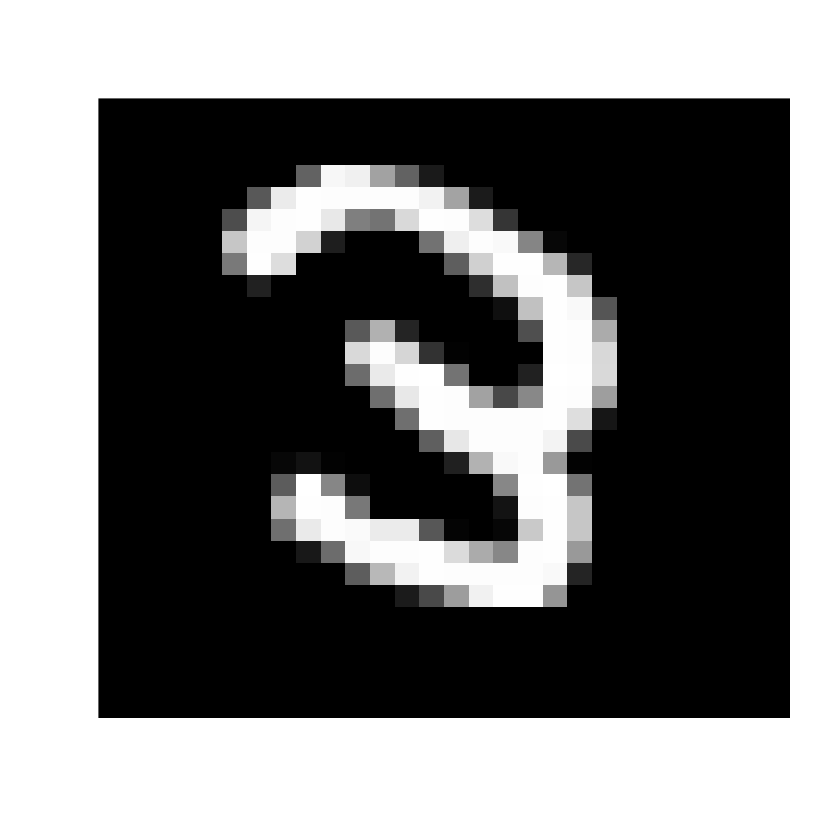

In [67]:
example_entry <- training_data[[1]]
example_x <- example_entry[[1]]
example_y <- example_entry[[2]]

# Y-vector looks like this:
print(example_y)
# It corresponds to digit:
print(which.max(example_y)-1)

# X-vector has length
print(length(example_x))

# We can think of it as a 28x28 matrix where entries are a shade of gray
ex_plot <- matrix(example_x, nrow=28, ncol=28, byrow=FALSE)
image(ex_plot, axes = FALSE, col = grey(seq(0, 1, length = 256)))

Let's train a neural net with one 100-neuron hidden-layer to predict (given 784 vector of gray intensity) the digit (from 0 to 9)

In [18]:
# Input and output neurons
input_neurons <- length(training_data[[1]][[1]])
output_neurons <- length(training_data[[1]][[-1]])

# Step 1. Initialise nueral network (bias and weights for layers)
# MNIST: 784, 100, 10 (one hidden-layer)
create_neural_net <- neuralnetwork(c(input_neurons, 100, output_neurons))

# Step 2. Train NN using SGD
print("THIS WILL TAKE 20-30 MINUTES...")
trained_net <- SGD(training_data=training_data,
                   testing_data=testing_data,
                   epochs=30, 
                   mini_batch_size=10,
                   lr=3,
                   C='ce',
                   sizes=create_neural_net[[1]],
                   num_layers=create_neural_net[[2]],
                   biases=create_neural_net[[3]], 
                   weights=create_neural_net[[4]],
                   verbose=TRUE)

[1] "THIS WILL TAKE 20-30 MINUTES..."
Epoch:  1  complete[1] 0.9274
Epoch:  2  complete[1] 0.9388
Epoch:  3  complete[1] 0.9452
Epoch:  4  complete[1] 0.9442
Epoch:  5  complete[1] 0.9518
Epoch:  6  complete[1] 0.9448
Epoch:  7  complete[1] 0.955
Epoch:  8  complete[1] 0.9504
Epoch:  9  complete[1] 0.9542
Epoch:  10  complete[1] 0.9621
Epoch:  11  complete[1] 0.9602
Epoch:  12  complete[1] 0.9588
Epoch:  13  complete[1] 0.9636
Epoch:  14  complete[1] 0.9641
Epoch:  15  complete[1] 0.9622
Epoch:  16  complete[1] 0.96
Epoch:  17  complete[1] 0.9602
Epoch:  18  complete[1] 0.9615
Epoch:  19  complete[1] 0.9643
Epoch:  20  complete[1] 0.9643
Epoch:  21  complete[1] 0.9664
Epoch:  22  complete[1] 0.967
Epoch:  23  complete[1] 0.9645
Epoch:  24  complete[1] 0.9666
Epoch:  25  complete[1] 0.9643
Epoch:  26  complete[1] 0.9661
Epoch:  27  complete[1] 0.9659
Epoch:  28  complete[1] 0.969
Epoch:  29  complete[1] 0.9649
Epoch:  30  complete[1] 0.9643
Training complete

In [ ]:
# Trained matricies:
biases <- trained_net[[1]]
weights <- trained_net[[-1]]

# Accuracy (train)
# CONFUSION TRAIN MATRIX
evaluate(training_data, biases, weights)  #0.98
# Accuracy (test)
# CONFUSION TEST MATRIX
evaluate(testing_data, biases, weights)  #0.96

[1] 8

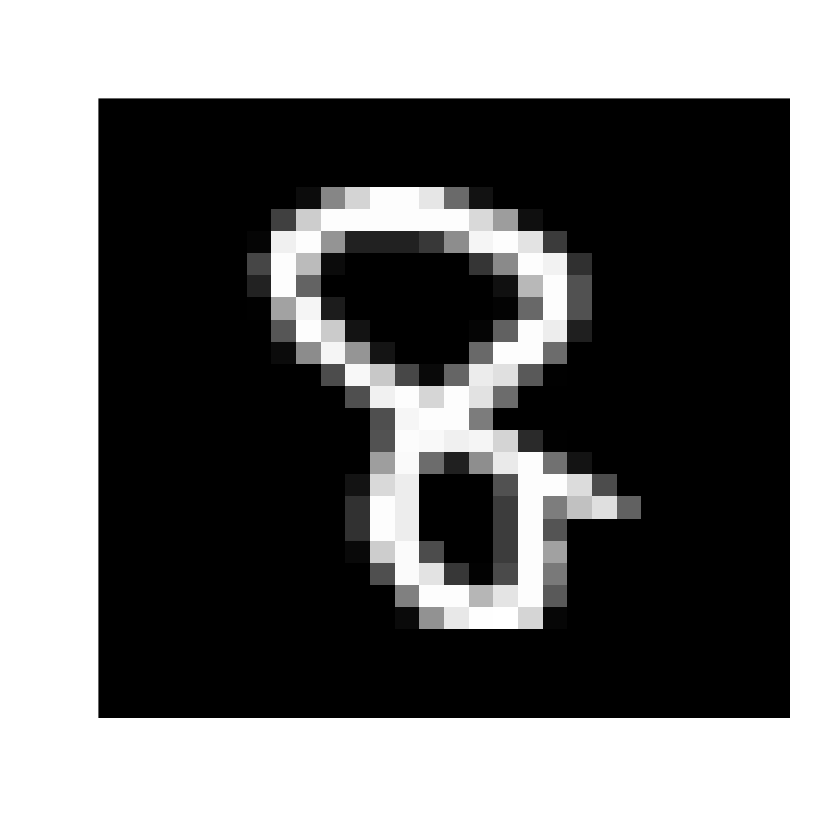

In [169]:
# Test this out with one example
# Do some machine-learning
test_entry <- testing_data[[42]]
test_x <- test_entry[[1]]
test_y <- test_entry[[2]]

# Input
image(matrix(test_x, nrow=28, ncol=28, byrow=FALSE),
      axes = FALSE, col = grey(seq(0, 1, length = 256)))

# Output
which.max(feedforward(test_x, biases, weights))-1

## Visualisations of boundary lines

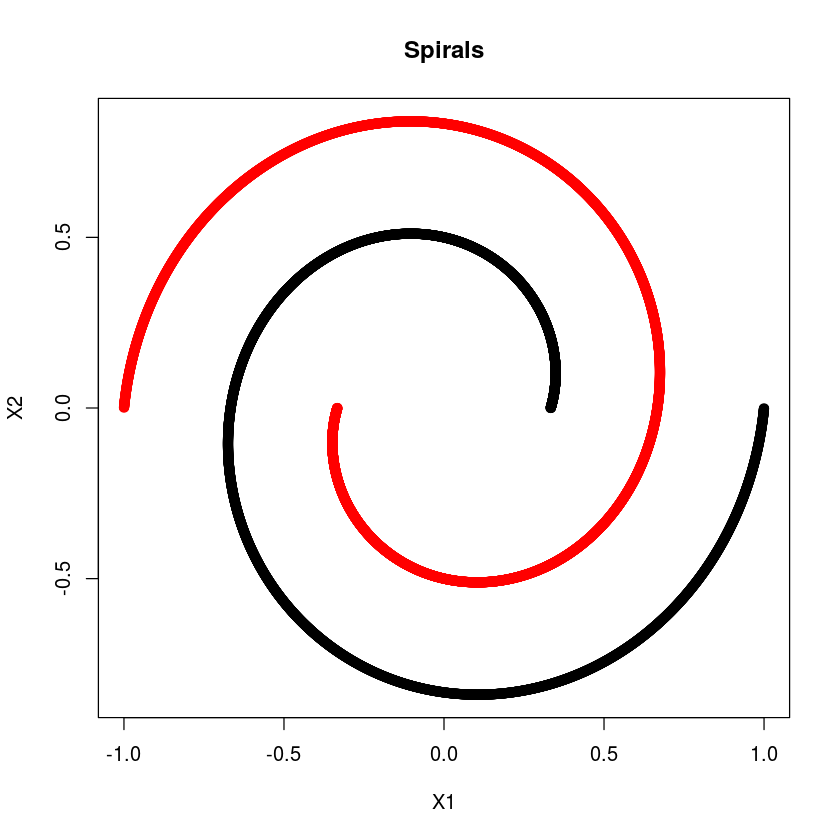

In [4]:
# Load some spiral data
library(mlbench)
data_df <- as.data.frame(mlbench.spirals(10000))

# Looks pretty cool
plot(x=data_df[,1], y=data_df[,2], cex = 1, col=data_df[,3],
     main = "Spirals", 
     xlab = "X1", ylab = "X2")

In [32]:
# Let's use all of this data for training
training_data <- train_test_from_df(df = data_df, predict_col_index = 3, 
                                    train_ratio = 1, scale_input = TRUE)[[1]]
input_neurons <- length(training_data[[1]][[1]])
output_neurons <- length(training_data[[1]][[-1]])

In [53]:
# Wrap a function that trains a network and plots the classification
plotBoundaryLinePerNeuron <- function(neurons, epochs)
{
  if (neurons>0){
      create_neural_net <- neuralnetwork(c(input_neurons, neurons, output_neurons))
  } else {
      create_neural_net <- neuralnetwork(c(input_neurons, output_neurons))
  }
    
  trained_net <- SGD(training_data=training_data,
                     testing_data=training_data,
                     epochs=epochs, 
                     mini_batch_size=500,
                     lr=3,
                     C='ce',
                     sizes=create_neural_net[[1]],
                     num_layers=create_neural_net[[2]],
                     biases=create_neural_net[[3]], 
                     weights=create_neural_net[[4]],
                     verbose=FALSE)
  b <- trained_net[[1]]
  w <- trained_net[[-1]]
  # Generate new-data
  nd <- as.data.frame(matrix(runif(100000, min=-1, max=1), ncol=2))
  # Get predictions
  nd$res <- as.factor(unlist(getPredictions(as.list(as.data.frame(t(nd))), b, w)
  # Print accuracy on training
  confusionm <- evaluate(training_data, b, w)
  # Plot predictions
  plot(x=nd[,1], y=nd[,2], col=nd[,3],
       main = paste0("Spiral Boundary Line - ", neurons, " neurons"), 
       xlab = "X1", ylab = "X2")
  # Original points
  points(x=data_df[,1], y=data_df[,2], col=ifelse(data_df[,3]==2, "orange", "grey"))
}

Training complete[1] 1


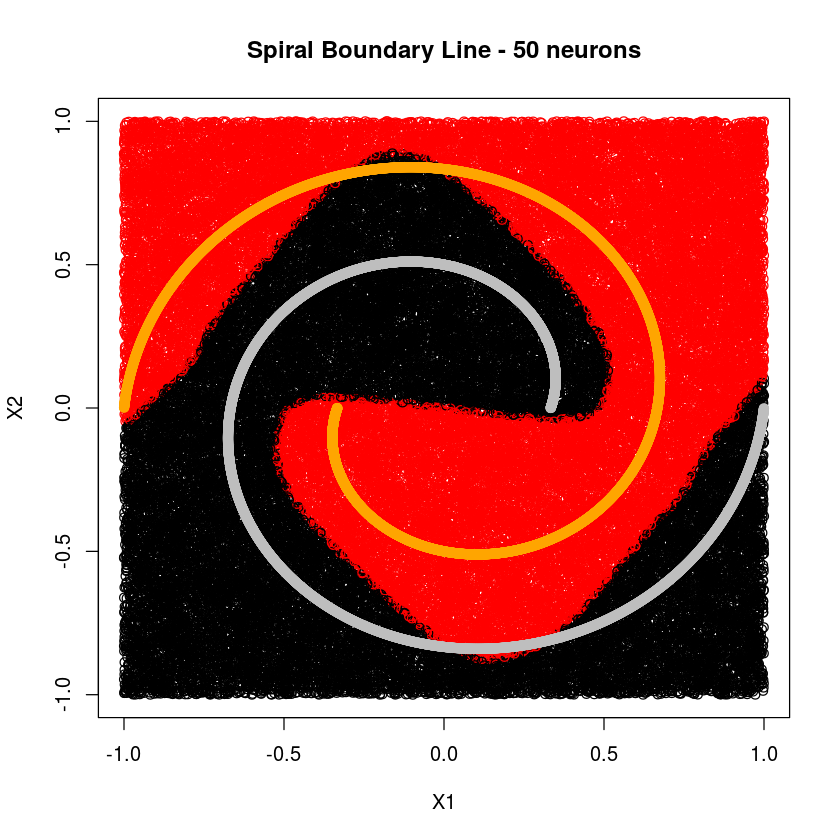

In [54]:
plotBoundaryLinePerNeuron(50, 80)

Training complete[1] 0.9961


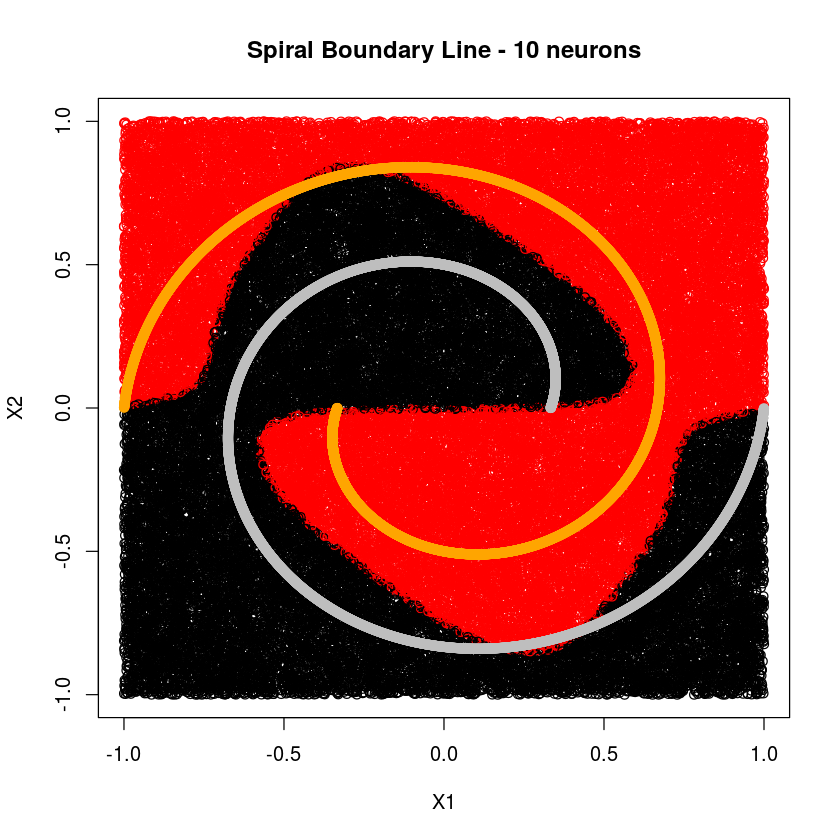

In [55]:
plotBoundaryLinePerNeuron(10, 80)

Training complete[1] 0.9875


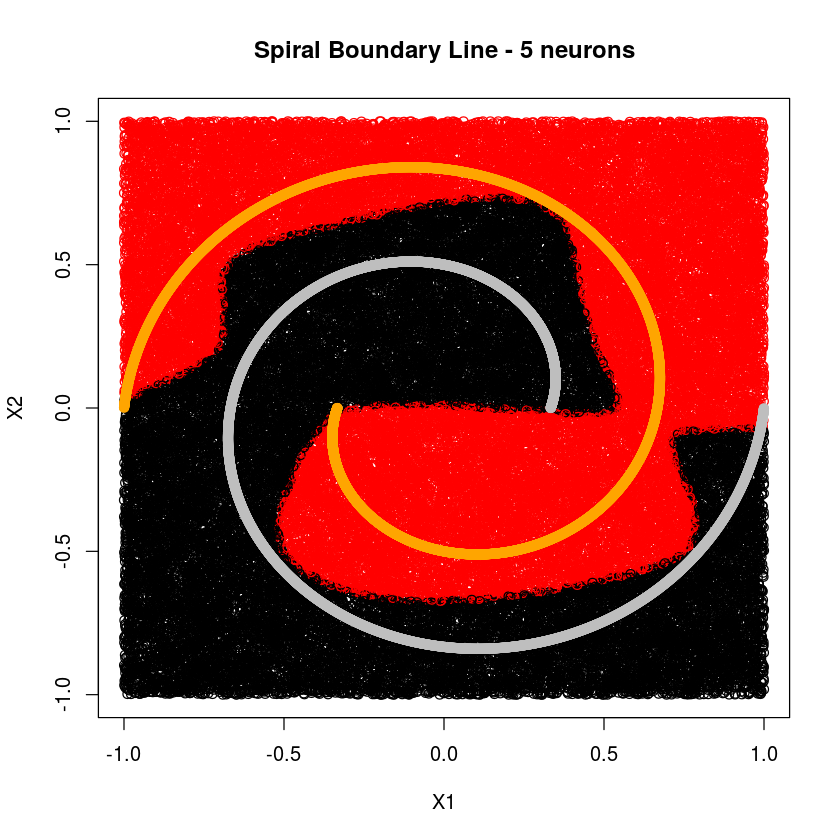

In [56]:
plotBoundaryLinePerNeuron(5, 80)

Training complete[1] 0.9708


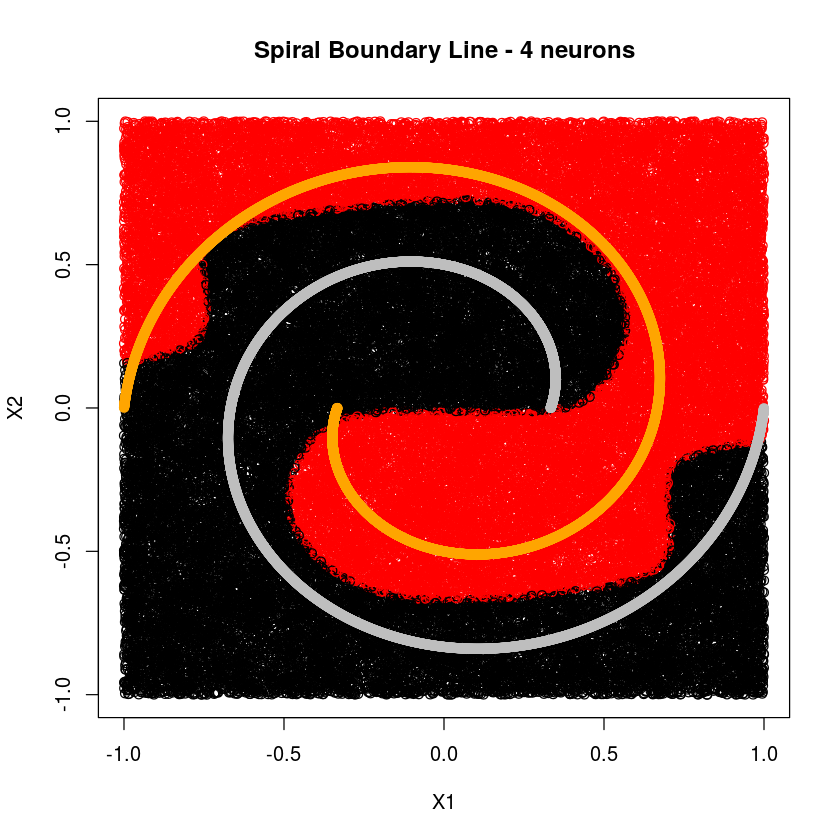

In [58]:
plotBoundaryLinePerNeuron(4, 120)

**It doesn't seem possible to draw fewer than 4 curves that split the classes, hence below 4 neurons we should start to see performance degrade - because the network doesn't enough params to fit the data. This can be a useful to exercise when trying to figure out how many neurons ones needs / over-fitting**

Training complete[1] 0.8021


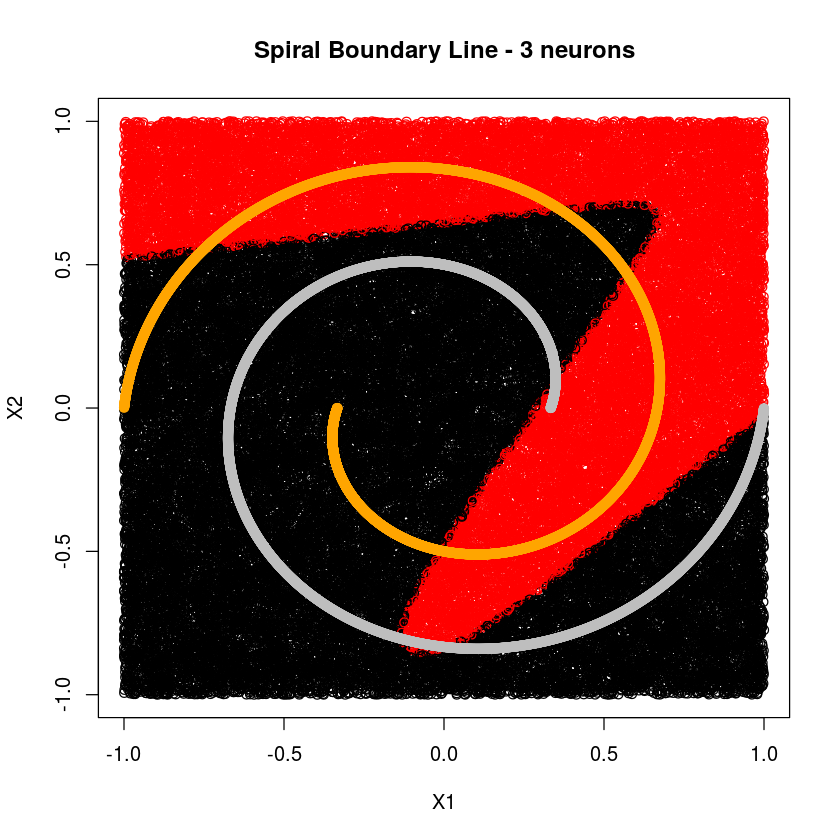

In [59]:
plotBoundaryLinePerNeuron(3, 120)

Training complete[1] 0.6444


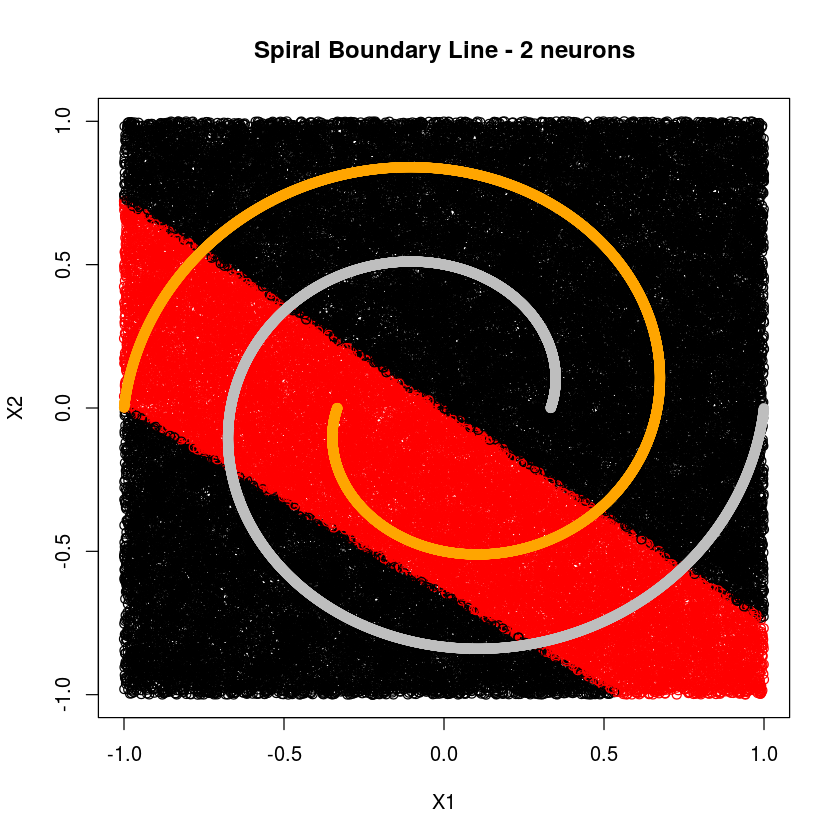

In [60]:
plotBoundaryLinePerNeuron(2, 120)

Training complete[1] 0.6105


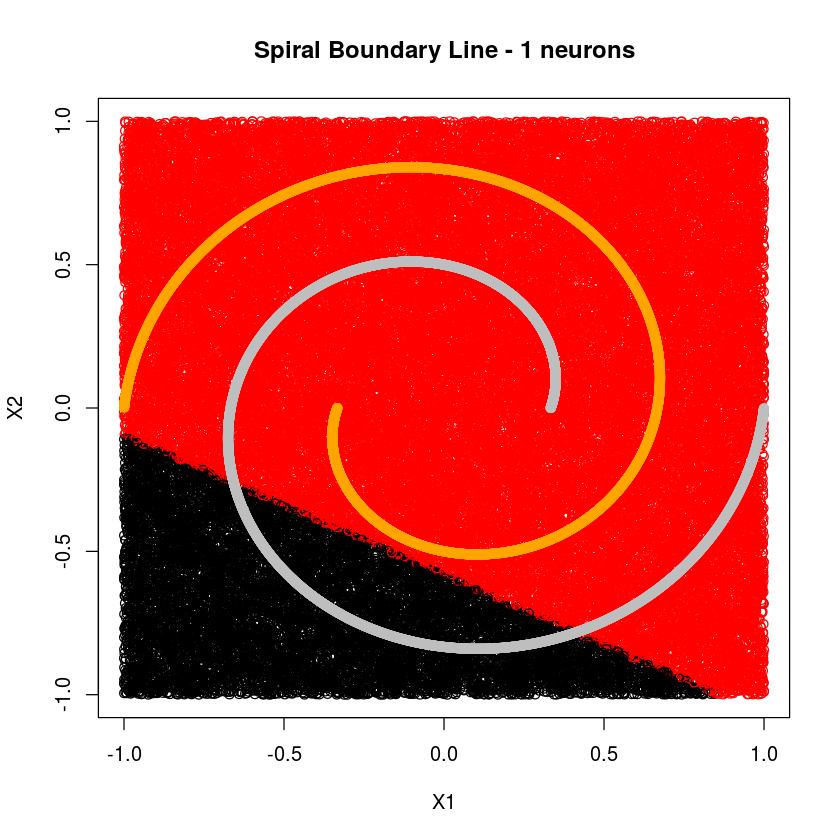

In [61]:
plotBoundaryLinePerNeuron(1, 120)